<a href="https://colab.research.google.com/github/Judykimani1/cord19_smoking_agent/blob/main/Smoking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 COVID & Smoking QnA Agent

This notebook will:

1. Install dependencies  
2. Download & extract CORD-19  
3. Filter by keywords & clean  
4. Extend with WHO COVID-19 data  
5. Keyword extraction & visualization  
6. Chunking, embeddings & FAISS index  
7. Gradio chatbot interface  
8. **Option A**: Validation tests  
9. **Option B**: Model-extension (NER & Sentiment)  


In [ ]:
# Install required libraries
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes \
            gradio keybert sentence-transformers faiss-cpu transformers wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.3/267.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13

## 2. Imports & Helpers

In [ ]:
import os
import re
import pandas as pd
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image, display
from tqdm import tqdm

In [ ]:
# LlamaIndex imports
from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer

## 3. Download & Extract CORD-19 (July 2020)

In [ ]:
# Upload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_path = "/content/drive/My Drive/filtered_cord19_text_sha.csv"
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    raise FileNotFoundError("Please upload 'filtered_cord19_text_sha.csv' to your Google Drive.")
df.head()

,sha,text
0,00624a8e79f31fccd9cc02ac643e8481d78898af,"A new coronavirus, named SARS-CoV-2 by the Wor..."
1,00eaa28403c40a1892c493a5ca2df4ac1e6896f8,"With the outbreak of the COVID-19 pandemia, ro..."
2,00ec6e927034a7b70159a09a6e54b74d08ac03c8,COVID19 and acute lymphoblastic leukemias of c...
3,012df38102699db78d83961b6dcb2c1138c810c1,The SARS-CoV-2 pandemic is unprecedented in ou...
4,0144d88cb339012dc1a4b29bbd72962e528baf92,The unprecedented health care scenario caused ...


# 4. FILTER SMOKING-RELATED ABSTRACTS

In [ ]:
smoking_keywords = ['smoking','smoke','tobacco','nicotine','cigarette','vaping','e-cigarette','secondhand']
covid_keywords   = ['covid','covid-19','coronavirus','sars-cov-2']
cancer_keywords  = ['lung cancer','cancer','tumor','carcinoma']
ALL_TERMS = smoking_keywords + covid_keywords + cancer_keywords
pattern = re.compile(r"\b(" + "|".join(map(re.escape, ALL_TERMS)) + r")\b", re.IGNORECASE)

In [ ]:
def contains_terms(text: str) -> bool:
    if pd.isna(text): return False
    return bool(pattern.search(text))

def clean_text(text: str) -> str:
    if not isinstance(text, str): return ""
    return re.sub(r"\[.*?\]|\s+", " ", text).strip()

# 5. FILTER & CLEAN THE CORD19 SLICE

In [ ]:
df['text'] = df['text'].astype(str)
filtered = df[df['text'].apply(contains_terms)].copy()
filtered['clean_text'] = filtered['text'].apply(clean_text)
print(f"[INFO] Filtered abstracts: {len(filtered):,} rows")

[INFO] Filtered abstracts: 1,492 rows


# 6. EXTEND WITH GPE DATASET
## Spatial Data for CORD-19 (COVID-19 ORDC)

Locations (GPE or LOC only) were extracted from CORD-19 full text articles [2020-03-20 release] using spaCy. The results were then geocoded with ArcGIS Online. In its current form, this data is uncleaned.

This dataset was produced by Charlie Harper and Ben Gorham of The Freedman Center for Digital Scholarship (Kelvin Smith Library) at Case Western Reserve University and made use of the High Performance Computing Resource in the Core Facility for Advanced Research Computing at Case Western Reserve University.

In [ ]:
gpe_path = "/content/drive/My Drive/gpe_or_loc_in_body.csv"
df_extended = pd.read_csv(gpe_path)
df_extended.head(4)

,sha,ner,sentence,sentence_start,sentence_end,source_x,title,doi,license,abstract,publish_time,authors,journal
0,0015023cc06b5362d332b3baf348d11567ca2fbb,PK,This is consistent with our earlier report des...,351,374,biorxiv,The RNA pseudoknots in foot-and-mouth disease ...,10.1101/2020.01.10.901801,biorxiv,The positive stranded RNA genomes of picornavi...,2020-01-11,"Ward, J. C. J.; Lasecka-Dykes, L.; Neil, C.; A...",NaN
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,China,The 2019-nCoV epidemic has spread across China...,0,21,medrxiv,Healthcare-resource-adjusted vulnerabilities t...,10.1101/2020.02.11.20022111,medrvix,We integrate the human movement and healthcare...,2020-02-12,Hanchu Zhou; Jianan Yang; Kaichen Tang; Qingpe...,NaN
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,Wuhan,The mass quarantine measure implemented in the...,21,56,medrxiv,Healthcare-resource-adjusted vulnerabilities t...,10.1101/2020.02.11.20022111,medrvix,We integrate the human movement and healthcare...,2020-02-12,Hanchu Zhou; Jianan Yang; Kaichen Tang; Qingpe...,NaN
3,004f0f8bb66cf446678dc13cf2701feec4f36d76,Hubei Province,The mass quarantine measure implemented in the...,21,56,medrxiv,Healthcare-resource-adjusted vulnerabilities t...,10.1101/2020.02.11.20022111,medrvix,We integrate the human movement and healthcare...,2020-02-12,Hanchu Zhou; Jianan Yang; Kaichen Tang; Qingpe...,NaN


In [ ]:
if not os.path.exists(gpe_path):
    print("[WARNING] GPE dataset not found; skipping extension")
    extended = filtered.copy()
else:
    gpe = pd.read_csv(gpe_path)

    # 2) If you didn’t have 'clean_abstract' originally, create it now:
    if "clean_abstract" not in gpe.columns:
        gpe["clean_abstract"] = gpe["abstract"].apply(clean_text)

    # 3) Select all the columns you actually need:
    keep_cols = ["sha", "title", "abstract", "clean_abstract", "doi", "publish_time"]
    gpe = gpe[[c for c in keep_cols if c in gpe.columns]].copy()

    # 4) Now filter & merge exactly as before:
    gpe = gpe[gpe["abstract"].apply(contains_terms)].copy()
    print(f"[INFO] GPE-filtered: {len(gpe):,} rows")

    extended = pd.concat([filtered, gpe], ignore_index=True)
    extended = extended.drop_duplicates(subset=["doi","sha"], keep="first")
    print(f"[INFO] Extended dataset: {len(extended):,} rows")


[INFO] GPE-filtered: 95,351 rows
[INFO] Extended dataset: 6,324 rows


In [ ]:
extended.to_csv("/content/drive/My Drive/extended_metadata.csv", index=False)

In [ ]:
extended.tail(10)

,sha,text,clean_text,title,abstract,clean_abstract,doi,publish_time
96625,fab32444594a7c25009ffcd48e91c923f5f0316f,NaN,NaN,The imperative to develop a human vaccine for ...,The Hendra virus (HeV) poses a significant cha...,The Hendra virus (HeV) poses a significant cha...,10.3402/iee.v5.29619,2015 Oct 29
96639,faec4bca24cb275ebc6c55e7cba3bd6a3b74df32,NaN,NaN,Expression and role of HEPIS in breast cancer,Human embryo lung cellular protein interacting...,Human embryo lung cellular protein interacting...,10.3892/ol.2019.10993,2019 Dec 17
96641,fb02396b27e7eba6cd6e52fec15c040a98cc0d48,NaN,NaN,Descriptive epidemiology and characteristics o...,BACKGROUND AND OBJECTIVES: Describe the epidem...,BACKGROUND AND OBJECTIVES: Describe the epidem...,10.5144/0256-4947.2015.203,2015 May-Jun
96710,fc363739ad7ec8d796aba6af478d986a4c0f5f3f,NaN,NaN,Neonatal infections in Saudi Arabia: Associati...,"In recent years, many studies have reported po...","In recent years, many studies have reported po...",10.5114/ceji.2015.50836,2015 Apr 22
96717,fc7c462f4b3c1a7e4ab9cf9d7be29353a8595a8c,NaN,NaN,Human Coronavirus EMC Is Not the Same as Sever...,"A newly identified betacoronavirus, human coro...","A newly identified betacoronavirus, human coro...",10.1128/mBio.00002-13,2013 Jan 15
96720,fce3506fcb7fa163babc7f4e959283ecbe346bc9,NaN,NaN,Middle East Respiratory Syndrome Coronavirus S...,Since the first imported case of Middle East r...,Since the first imported case of Middle East r...,10.3346/jkms.2015.30.11.1701,2015 Nov 16
96732,fe2b70a4317057c021120d2281f2d7796c742e86,NaN,NaN,Inhibition of Triggering Receptor Expressed on...,Alcoholic liver disease (ALD) is characterized...,Alcoholic liver disease (ALD) is characterized...,10.1002/hep4.1269,2018 Oct 29
96763,fef0bb9eaac69559d0ff2f92ff83e0affd4435f0,NaN,NaN,Pathogenic Influenza Viruses and Coronaviruses...,The broad range and diversity of interferon-st...,The broad range and diversity of interferon-st...,10.1128/mBio.01174-14,2014 May 20
96767,ff2ac3737c6edf81ff29b8d72c3abc2b3df5b344,NaN,NaN,Current perspectives in transfusion-transmitte...,"BACKGROUND: In August 2009, a group from the A...","BACKGROUND: In August 2009, a group from the A...",10.1111/voxs.12070,2014 Jul 28
96820,ff5a79ed22ea416e6d89caad1cf0d83dbc741a4b,NaN,NaN,Understanding Human Coronavirus HCoV-NL63,Even though coronavirus infection of humans is...,Even though coronavirus infection of humans is...,10.2174/1874357901004010076,2010 May 25


In [ ]:
# if you also have a `full_text` JSON load, you could do:
extended["abstract"] = extended["abstract"].fillna(extended["text"])

In [ ]:
import json
from pathlib import Path

def load_full_text(sha):
    p = Path("data/document_parses/json_files") / f"{sha}.json"
    if not p.exists():
        return None
    js = json.loads(p.read_text())
    # join all body_text paragraphs
    return " ".join([sec["text"] for sec in js.get("body_text", [])])

# apply only to rows where abstract is NaN
mask = extended["abstract"].isna()
extended.loc[mask, "abstract"] = extended.loc[mask, "sha"].apply(load_full_text)

In [ ]:
extended["abstract"] = extended["abstract"].fillna("")
extended = extended.dropna(subset=["abstract"]).reset_index(drop=True)

In [ ]:
extended["clean_abstract"] = extended["abstract"].apply(clean_text)

In [ ]:
extended = extended.drop(columns=['doi', 'publish_time', 'title'])

In [ ]:
extended.head(10)

,sha,text,clean_text,abstract,clean_abstract
0,00624a8e79f31fccd9cc02ac643e8481d78898af,"A new coronavirus, named SARS-CoV-2 by the Wor...","A new coronavirus, named SARS-CoV-2 by the Wor...","A new coronavirus, named SARS-CoV-2 by the Wor...","A new coronavirus, named SARS-CoV-2 by the Wor..."
1,00eaa28403c40a1892c493a5ca2df4ac1e6896f8,"With the outbreak of the COVID-19 pandemia, ro...","With the outbreak of the COVID-19 pandemia, ro...","With the outbreak of the COVID-19 pandemia, ro...","With the outbreak of the COVID-19 pandemia, ro..."
2,00ec6e927034a7b70159a09a6e54b74d08ac03c8,COVID19 and acute lymphoblastic leukemias of c...,COVID19 and acute lymphoblastic leukemias of c...,COVID19 and acute lymphoblastic leukemias of c...,COVID19 and acute lymphoblastic leukemias of c...
3,012df38102699db78d83961b6dcb2c1138c810c1,The SARS-CoV-2 pandemic is unprecedented in ou...,The SARS-CoV-2 pandemic is unprecedented in ou...,The SARS-CoV-2 pandemic is unprecedented in ou...,The SARS-CoV-2 pandemic is unprecedented in ou...
4,0144d88cb339012dc1a4b29bbd72962e528baf92,The unprecedented health care scenario caused ...,The unprecedented health care scenario caused ...,The unprecedented health care scenario caused ...,The unprecedented health care scenario caused ...
5,017fa72e2ab985213af241fd27da200b57a2ff95,The COVID-19 pandemic is impacting all urologi...,The COVID-19 pandemic is impacting all urologi...,The COVID-19 pandemic is impacting all urologi...,The COVID-19 pandemic is impacting all urologi...
6,01875a437a28422a2b857efab9d5c4b113bcdfbb,Bispecific monoclonal antibodies (BsMAb) are u...,Bispecific monoclonal antibodies (BsMAb) are u...,Bispecific monoclonal antibodies (BsMAb) are u...,Bispecific monoclonal antibodies (BsMAb) are u...
7,0197f22ffbd2d32a556d4c2490fa2c72583faef5,Aims: It is important to identify characterist...,Aims: It is important to identify characterist...,Aims: It is important to identify characterist...,Aims: It is important to identify characterist...
8,01f7ebedfcedde79ac1595a1561fa2e735a76622,There are growing concerns that the UK COVID-1...,There are growing concerns that the UK COVID-1...,There are growing concerns that the UK COVID-1...,There are growing concerns that the UK COVID-1...
9,02049ffbdb20997055c4def3516af0e6e40dd427,ADAR1 isoforms are adenosine deaminases that e...,ADAR1 isoforms are adenosine deaminases that e...,ADAR1 isoforms are adenosine deaminases that e...,ADAR1 isoforms are adenosine deaminases that e...


# 7. VALIDATION REPORT & BASIC VIZ

In [ ]:
report = {
    "original_rows": len(df),
    "filtered_rows": len(filtered),
    "gpe_rows": len(gpe),
    "extended_rows": len(extended),
    "null_abstracts": filtered['text'].isna().sum(),
    "avg_length": filtered['text'].str.split().map(len).mean()
}
pd.DataFrame([report]).to_csv("/content/drive/My Drive/validation_report.csv", index=False)
display(pd.DataFrame([report]).T)

,0
original_rows,1507.000000
filtered_rows,1492.000000
gpe_rows,95351.000000
extended_rows,6324.000000
null_abstracts,0.000000
avg_length,2588.671582


In [ ]:
# Keyword frequency plot
freq = {term: extended['abstract'].str.contains(term, case=False).sum() for term in ALL_TERMS}
plt.figure(figsize=(10,4))
sns.barplot(x=list(freq.keys()), y=list(freq.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Term Frequency")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/term_frequency.png")
plt.close()

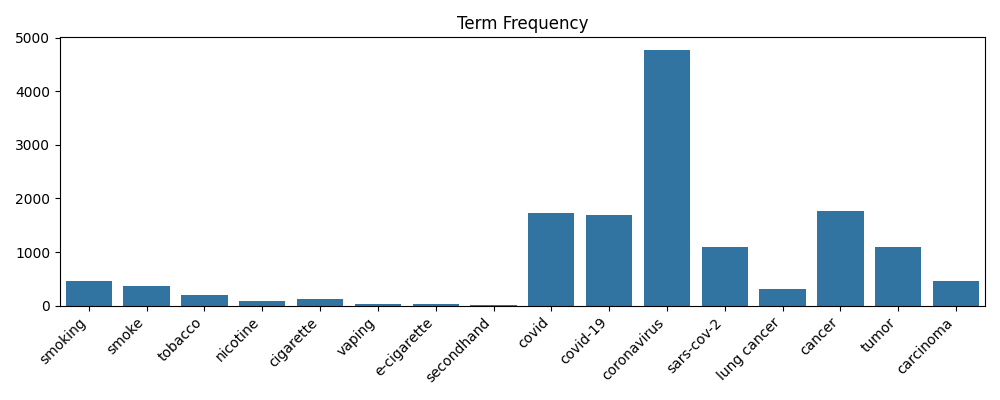

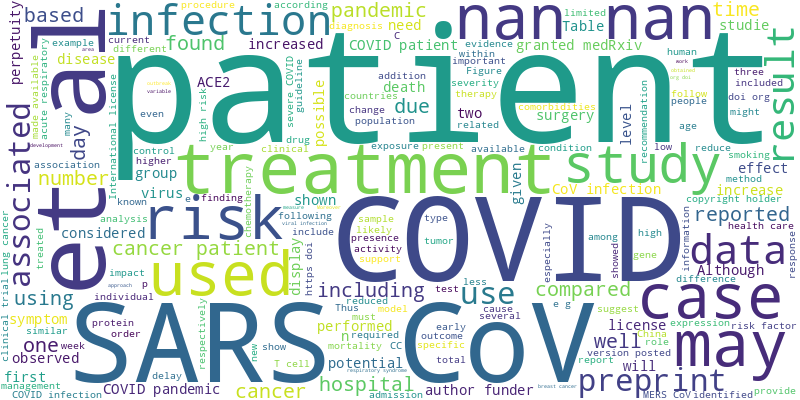

In [ ]:
# Wordcloud of extended abstracts
wc = WordCloud(width=800, height=400, background_color="white")
extended['text'] = extended['text'].astype(str).fillna('')
wc.generate(" ".join(extended['text']))
wc.to_file("/content/drive/My Drive/wordcloud.png")
display(Image("/content/drive/My Drive/term_frequency.png"))
display(Image("/content/drive/My Drive/wordcloud.png"))

# 8. KEYWORD EXTRACTION WITH KeyBERT

In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT("distilbert-base-nli-mean-tokens")

In [ ]:
all_kws = []
extended['clean_text'] = extended['clean_text'].fillna('')
for txt in tqdm(extended['clean_text'], desc="Extracting keywords (GPU)"):
    kws = [k for k,_ in kw_model.extract_keywords(txt, top_n=3)]
    all_kws.extend(kws)

Extracting keywords (GPU): 100%|██████████| 6324/6324 [05:03<00:00, 20.82it/s]


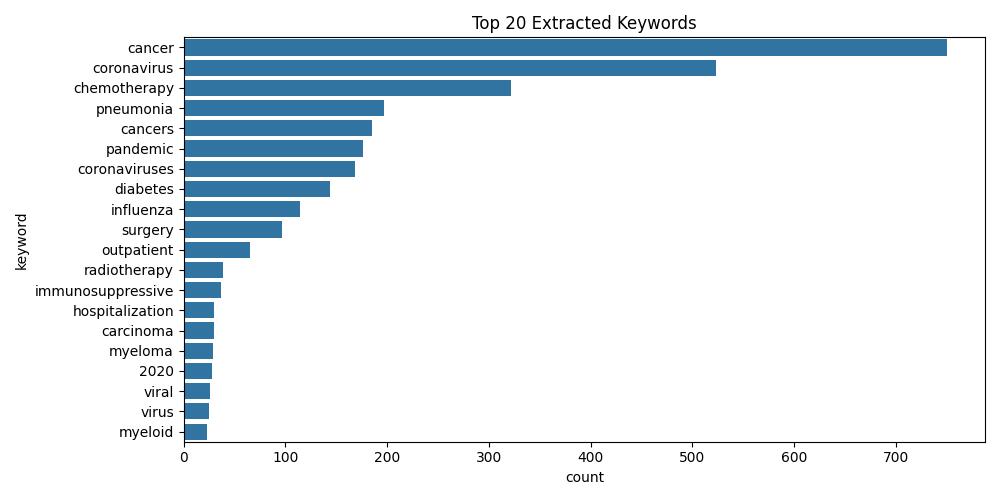

In [ ]:
top20 = Counter(all_kws).most_common(20)
kw_df = pd.DataFrame(top20, columns=['keyword','count'])
kw_df.to_csv("/content/drive/My Drive/top_keywords.csv", index=False)
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='keyword', data=kw_df)
plt.title("Top 20 Extracted Keywords")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/top_keywords.png")
plt.close()
display(Image("/content/drive/My Drive/top_keywords.png"))

# 9. CHUNK ABSTRACTS FOR INDEXING

In [ ]:
embed_model = HuggingFaceEmbedding(
    model_name="pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb",
    device="cuda"
)
Settings.embed_model = embed_model

In [ ]:
chunks = []
for txt in tqdm(extended['clean_text'], desc="Chunking"):
    words = txt.split()
    for i in range(0, len(words), 150):
        chunk = " ".join(words[i:i+150])
        chunks.append(Document(text=chunk))

print(f"[INFO] Created {len(chunks):,} chunks")

Chunking: 100%|██████████| 6324/6324 [00:01<00:00, 4217.72it/s]

[INFO] Created 26,224 chunks


In [ ]:
index = VectorStoreIndex.from_documents(chunks, show_progress=True, insert_batch_size=len(chunks))
index.storage_context.persist(persist_dir="storage")

Parsing nodes:   0%|          | 0/26224 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/26224 [00:00<?, ?it/s]

# 9. QUERY EXAMPLE

In [ ]:
storage = StorageContext.from_defaults(persist_dir="storage")
index = load_index_from_storage(storage)

In [ ]:
from llama_index.llms.huggingface import HuggingFaceLLM

# 1. Create your HF LLM
hf_llm = HuggingFaceLLM(
    model_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    tokenizer_name="colesmcintosh/Llama-3.2-1B-Instruct-Mango",
    context_window=2048,
    max_new_tokens=256,
    device_map="cuda:0",
    generate_kwargs={"temperature":0.7, "do_sample":True},
)

# 2. Build the query engine with the LLM instance directly
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=hf_llm # Pass the hf_llm instance directly
)

# 3. Run your query
response = query_engine.query("What are the effects of smoking.")
print(response.response)

adapter_config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

 Smuggling smoking is associated with an increased risk of COVID-19 infection. Smoking is known to cause lung damage through the activation of inflammatory cytokines and programmed cell death in the pulmonary tissue and direct actions on circulating immune cells such as T cell.  Nicotine is a known carcinogen that can cause lung cancer. In addition to smoking, e-cigarettes, tobacco, and secondhand smoke are also known to cause respiratory problems such as asthma and COPD. In fact, studies have shown that smoking is associated with increased ACE2 expression in the lung, which may underlie enhanced exposure to the SARS-CoV-2 spike protein, and that smoking is also associated with increased mortality rate among smokers with COVID-19 infections. 14.4% of patients with COVID-19 were found to be smokers, and 15.3% of patients were found to be former smokers who used NRT. 17.7% of patients were found to be former smokers who used e-cigarettes. 15.6% of patients were found to be former smokers

# 10. BUILD CHAT ENGINE & LAUNCH GRADIO

In [ ]:
Settings.llm = hf_llm

In [ ]:
chat_engine = index.as_chat_engine(
    chat_mode="context",
    memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
    system_prompt=(
        "You are a medical chatbot specialized in answering questions about Smoking, COVID-19, "
        "lung cancer, and related topics. Provide factual, safe responses based on the data."
    ),
    llm=hf_llm
)

# 11.  NER & SENTIMENT ANNOTATION

In [ ]:
from transformers import pipeline

# 1. Initialize the NER pipeline
ner = pipeline(
    task="ner",
    model="d4data/biomedical-ner-all",
    tokenizer="d4data/biomedical-ner-all",
    grouped_entities=True,
    device=0
)

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [ ]:
# 2. Updated chat function that annotates the generated answer
def chat_fn_with_ner(user_input, history=[]):
    # Get the response from the chat engine
    result = chat_engine.chat(user_input)
    answer = result.response

    # Run NER on the answer
    entities = ner(answer)

    # Append to chat history
    history.append((user_input, answer))

    # Return updated history and NER entities
    return history, history, entities

🧠 COVID & Smoking QnA Chatbot

This Gradio-based app allows users to ask medical questions related to COVID-19, smoking, and lung cancer. It features:

✅ LLM-powered chatbot (Llama 3.2 1B Mango)

✅ Named Entity Recognition (Biomedical NER)

✅ Sentiment Analysis (on user & bot text)

✅ Model dropdown for future extensibility

In [ ]:
from transformers import pipeline
import gradio as gr

# 1. Initialize NER and Sentiment Analysis Pipelines
ner_pipeline = pipeline(
    task="ner",
    model="d4data/biomedical-ner-all",
    tokenizer="d4data/biomedical-ner-all",
    grouped_entities=True,
    device=0
)

sentiment_pipeline = pipeline(
    task="sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",  # Or replace with a medical sentiment model
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=0
)

# 2. Chat function with NER and Sentiment Analysis
def full_chat_fn(user_input, history=[]):
    # Get response from chat engine
    result = chat_engine.chat(user_input)
    answer = result.response

    # Run NER on the generated answer
    ner_results = ner_pipeline(answer)

    # Run Sentiment Analysis on the answer
    sentiment_results = sentiment_pipeline(answer)

    # Append to chat history
    history.append((user_input, answer))

    return history, history, ner_results, sentiment_results

# 3. Gradio Wrapper
def wrapped_chat(user_input, history):
    return full_chat_fn(user_input, history)

# 4. Interface Definition
chatbot = gr.Chatbot(label="🧠 Medical Chat")
state   = gr.State([])

iface = gr.Interface(
    fn=wrapped_chat,
    inputs=[gr.Textbox(lines=2, label="Your Question", placeholder="e.g., What are the effects of smoking on COVID-19 patients?"), state],
    outputs=[
        chatbot,                 # Updated chat history
        state,                   # Stateful memory
        gr.JSON(label="🔬 Named Entities"),
        gr.JSON(label="❤️ Sentiment Analysis")
    ],
    title="🦠 COVID & Smoking QnA Agent",
    description="Ask about COVID-19, smoking, lung cancer, or related medical topics. Output includes NER and sentiment insights."
)

iface.launch()


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-75-5a9adc2a824f>:42: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="🧠 Medical Chat")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ef2d70a2d60708ae6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
